<a href="https://colab.research.google.com/github/spacemaninSeoul/justpractice/blob/main/Using_Neural_Network_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. MNIST

MNIST 데이터셋은 0부터 9까지의 숫자를 예측하는 다중 분류(multi classification)문제로, 과거 NIST(National Institute of Standards of Technology, 미국 국립표준기술연구소)에서 수집한 손으로 직접 쓴 흑백의 숫자이다. 데이터는 숫자 이미지(28x28)와 각 이미지에 해당하는 레이블(0부터 9까지)로 이루어져 있고, 60,000개의 학습 데이터와 10,000개의 테스트 데이터로 구성되어 있다.

## 1) 데이터 살펴보기

In [1]:
# MNIST 데이터셋 다운받기
from tensorflow.keras.datasets.mnist import load_data

# 텐서플로 저장소에서 데이터를 다운 받는다.
(x_train, y_train), (x_test, y_test) = load_data(path='mnist.npz')

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
# 데이터의 형태 파악하기
# 학습 데이터
print(x_train.shape, y_train.shape)
print(y_train)

# 테스트 데이터
print(x_test.shape, y_test.shape)
print(y_test)

(60000, 28, 28) (60000,)
[5 0 4 ... 5 6 8]
(10000, 28, 28) (10000,)
[7 2 1 ... 4 5 6]


학습 데이터는 60,000개의 숫자 이미지 데이터와 0에서 9로 이루어진 레이블로 구성된 것을 알 수 있다.

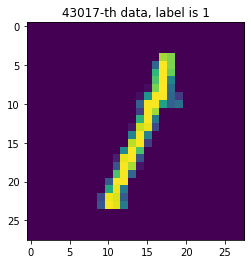

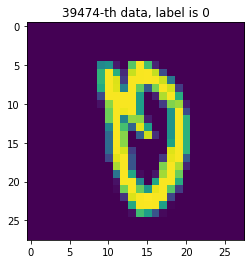

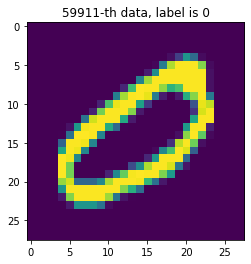

In [10]:
# 데이터 그려보기
import matplotlib.pyplot as plt
import numpy as np

sample_size = 3
# 0~59,999의 범위에서 무작위로 세 개의 정수를 뽑는다.
random_idx = np.random.randint(60000, size=sample_size)


for idx in random_idx:
  img = x_train[idx, :]
  label = y_train[idx]
  plt.figure()
  plt.imshow(img)
  plt.title('%d-th data, label is %d' % (idx, label))

학습 도중 모델의 검증을 위해 미리 검증 데이터셋을 만든다.

In [11]:
# 검증 데이터 만들기
from sklearn.model_selection import train_test_split

# 훈련/검증 데이터를 0.7/0.3의 비율로 분리한다.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=777)

print(f'훈련 데이터 {x_train.shape} 레이블 {y_train.shape}')
print(f'검증 데이터 {x_val.shape} 레이블 {y_val.shape}')

훈련 데이터 (42000, 28, 28) 레이블 (42000,)
검증 데이터 (18000, 28, 28) 레이블 (18000,)


모델 학습을 위한 전처리 과정

In [14]:
# 모델 입력을 위한 데이터 전처리
num_x_train = x_train.shape[0]
num_x_val = x_val.shape[0]
num_x_test = x_test.shape[0]

# 모델의 입력으로 사용하기 위한 전처리 과정이다.
x_train = (x_train.reshape((num_x_train, 28 * 28))) / 255
x_val = (x_val.reshape((num_x_val, 28 * 28))) / 255
x_test = (x_test.reshape((num_x_test, 28 * 28))) / 255

print(x_train.shape)

(42000, 784)


Dense층에 데이터를 입력하기 위해 2차원 배열로 이루어진 숫자 이미지 데이터를 1차원 배열로 변환해야 한다. 예저 코드에서 (28, 28) 형태의 데이터를 784차원의 1차원 배열로 변환한 것을 볼 수 있다. 신경망은 입력 데이터의 스케일에 아주 민감하므로 적절한 전처리 과정이 필수이다. 이에 대한 한 가지 큰 이유로는 그래디언트 손실(Gradient Vanishing)과 그래디언트 폭발(Gradient Exploding)로 인해 학습이 진행되지 않기 때문입니다. 우리가 사용할 숫자 이미지 데이터는 각 픽셀 값이 0~255의 범위에 있기 때문에 255로 나누어 주었다. 이를 다시 표현하면 MinMax 알고리즘을 적용한 것과 같다.



경사 하강법을 사용할때 딥 러닝은 출력층에서 입력층으로 오차 그래디언트를 전파시키는 역전파 알고리즘을 사용한다. 하지만 이 알고리즘은 하위층으로 갈 수록 그래디언트가 작아지게 되어 하위층의 연결 가중치가 변경이 되지 않는 현상이 발생합니다. 이 문제를 그래디언트 손실이라고 합니다. 반대로 가중치가 너무 크게 변경된다면 그 현상을 그래디언트 폭주라고 합니다. 


In [16]:
# 모델 입력을 위한 레이블 전처리
from tensorflow.keras.utils import to_categorical

# 각 데이터의 레이블을 범주형 형태로 변경한다.
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print(y_train)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 2) 모델 구성하기

Dense층을 여러 개 쌓아보도록한다. 항상 데이터를 입력받는 첫 번쨰 층은 데이터의 형태를 명시해야 한다는 점을 기억해야 한다. 모델은 784차원의 데이터를 입력으로 받고, 열 개의 출력을 갖는다.

In [17]:
# 모델 구성하기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
# 입력 데이터의 형태를 꼭 명시해야 한다.
# 784차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense층
model.add(Dense(64, activation = 'relu', input_shape = (784, )))
model.add(Dense(32, activation = 'relu')) # 32개의 출력을 갖는 Dense층
model.add(Dense(10, activation = 'softmax')) # 10개의 출력을 갖는 신경망

범주형 데이터를 다루기에 마지막 층에서 소프트맥스 함수를 사용했다. 소프트맥스 함수에서 출력값의 의미는 해당 클래스에 속할 값이며, 출력값의 합은 항상 1이다. 이 때문에 소프트맥스 함수의 출력값을 확률로서 해석할 수 있다.

소프트맥스 함수는 일반적으로 확률을 구하는 방법과 비슷하므로 각 클래스에 해당하는 값들이 서로 영향을 줄 수 있어 비교에 용이하다.

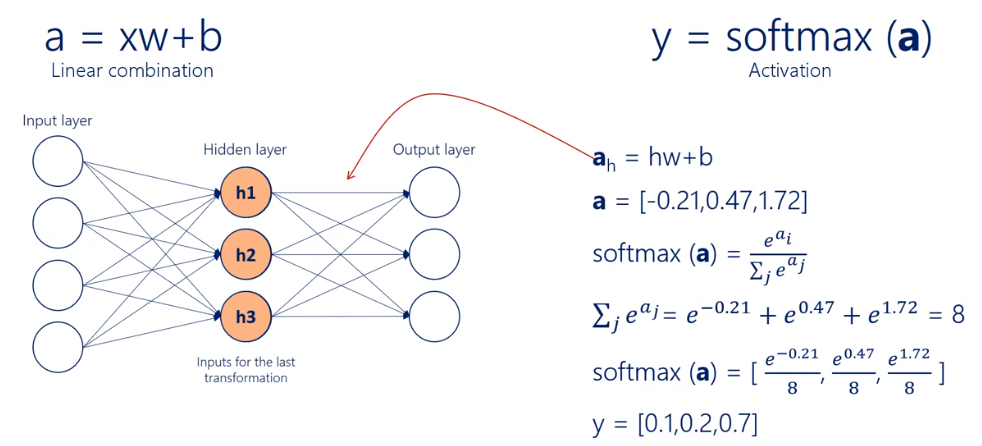

다음 예제에서 시그모이드 함수와 소프트맥스 함수를 통해 얻어지는 출력값을 비교한다.

In [18]:
# 소프트맥스와 시그모이드 값의 비교
def softmax(arr):
  m = np.max(arr)
  arr = arr - m # exp의 오버플로우 방지
  arr = np.exp(arr)
  return arr / np.sum(arr)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

case_1 = np.array([3.1 ,3.0, 2.9])
case_2 = np.array([2.0, 1.0, 0.7])

np.set_printoptions(precision=3) # numpy 소수점 제한
print(f'sigmoid {sigmoid(case_1)}, softmax {softmax(case_1)}')
print(f'sigmoid {sigmoid(case_2)}, softmax {softmax(case_2)}')

sigmoid [0.957 0.953 0.948], softmax [0.367 0.332 0.301]
sigmoid [0.881 0.731 0.668], softmax [0.61  0.224 0.166]


시그모이드 함수를 통해 얻은 값의 비교보다 소프트맥스 함수를 통해 얻은 값의 비교가 훨씬 수월한 것을 알 수 있다.

모델 구성의 마지막 단계는 손실 함수, 옵티 마이저, 평가지표를 설정하는 것이다. 다중 분류 문제에서의 손실 함수는 categorical_crossentropy 함수를 사용한다. 크로스 엔트로피(cross entropy)는 정보이론에서 파생되었으며, 이를 손실 함수로 사용했을 때 실제값과 예측값이 같은 값을 가지는 방향으로 학습된다. 서로의 값이 틀린 경우에는 로그 함수의 특징에 따라 무한대로 발산하게 되고 동일한 경우는 0으로 수렴하기 때문이다.

In [19]:
# 학습과정 설정
model.compile(optimizer='adam',# 옵티마이저 : Adam
              loss = 'categorical_crossentropy', # 손실함수 : categorical_crossentropy
              metrics = ['acc'], # 모니터링할 평가지표 : acc
)

주로 사용하는 Adam 옵티마이저의 기본 학습률은 0.001로 설정되어 있기에 변경하지 않고 사용한다.

## 3) 모델 학습

학습 도중 모델의 검증을 위해 미리 만들어둔 검증 데이터셋을 활용한다. validation_data 인자에 검증 데이터셋을 전달했으므로 매 에폭의 끝에서 이를 사용하여 학습중인 모델에 대한 검증을 진행한다. 모델은 128의 배치 크기를 사용하고 전체 데이터를 30회 반복한다.

In [20]:
# 모델 학습
history = model.fit(x_train, y_train,
                    epochs = 30,
                    batch_size = 128,
                    validation_data = (x_val, y_val))

Epoch 1/30
329/329 [==============================] - 2s 4ms/step - loss: 0.5201 - acc: 0.8544 - val_loss: 0.2522 - val_acc: 0.9308
Epoch 2/30
329/329 [==============================] - 1s 4ms/step - loss: 0.2148 - acc: 0.9375 - val_loss: 0.1952 - val_acc: 0.9445
Epoch 3/30
329/329 [==============================] - 1s 4ms/step - loss: 0.1618 - acc: 0.9535 - val_loss: 0.1621 - val_acc: 0.9542
Epoch 4/30
329/329 [==============================] - 1s 4ms/step - loss: 0.1327 - acc: 0.9623 - val_loss: 0.1498 - val_acc: 0.9567
Epoch 5/30
329/329 [==============================] - 1s 4ms/step - loss: 0.1131 - acc: 0.9674 - val_loss: 0.1407 - val_acc: 0.9598
Epoch 6/30
329/329 [==============================] - 1s 4ms/step - loss: 0.0971 - acc: 0.9718 - val_loss: 0.1300 - val_acc: 0.9609
Epoch 7/30
329/329 [==============================] - 1s 4ms/step - loss: 0.0855 - acc: 0.9749 - val_loss: 0.1240 - val_acc: 0.9629
Epoch 8/30
329/329 [==============================] - 1s 4ms/step - loss: 0.

이제 모델의 학습 과정을 그리도록 한다. model.fit() 함수는 History 객체를 반환한다. 이 객체는 History 속성이 있는데, 학습 중 학습 데이터뿐만 아니라 검증 데이터의 손실값과 평가지표의 값을 기록한다. History는 이런 값을 사전(dictionary) 형태로 저장하고 있다.

In [21]:
# history를 통해 확인할 수 있는 값 출력하기
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

검증 데이터를 통해 얻을 수 있는 손실값 또는 평가지표에는 'val_'이라는 수식어가 붙는다.

History 객체를 통해 손실값과 정확도를 그림으로 그려보도록 한다. 에폭이 진행되면서 손실값과 평가지표를 직접 모니터링할 수도 있지만, 모델의 history를 사용하여 학습 과정을 그래프로 그려보면 결과를 더욱 직관적으로 확인할 수 있다.

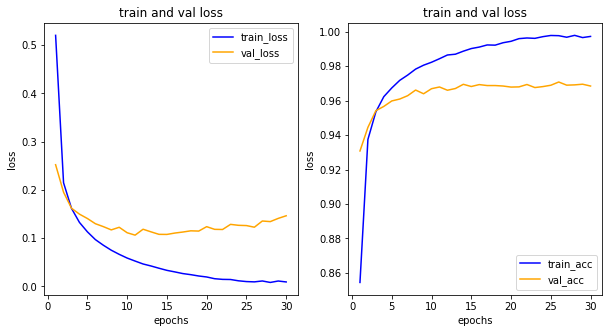

In [22]:
# 학습 결과 그리기.
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우에는 val_ 수식어가 붙는다.

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 5))

# 학습 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color='orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color='blue', label='train_acc')
ax2.plot(epochs, val_acc, color='orange', label='val_acc')
ax2.set_title('train and val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()

plt.show()

위에서 대략 5에폭까지는 올바르게 학습되고 있지만, 그 이후에는 두 그래프가 점점 벌어지는 모습을 볼 수 있다. 학습 과정에서 이와 같은 현상이 나타났을 때, 모델이 과대적합되었다고 표현할 수 있다. 과대적합 문제가 나타날 경우 데이터 특성, 모델 구조 등을 수정하고 재학습시키는 방법이 있지만, 먼저 과대적합이 진행되기 전(위의 경우에서는 5에폭)까지의 모델을 사용하여 결과를 확인해보고 기록해두는 것이 좋다.

## 4) 예측하고 정답과 비교하기

model.evaluate() 함수를 사용해 모델 성능을 확인한다.

In [23]:
# 모델 평가
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1374 - acc: 0.9703


[0.1373555064201355, 0.970300018787384]